In [80]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [81]:
IN_DIR = "kaggle/input/apl-2025-spring-smoker-status"
OUT_DIR = "kaggle/output"

# Data Preperation

## Reading

First read the data from the files:

In [82]:
train_data = pd.read_csv(f"{IN_DIR}/train.csv")
test_data = pd.read_csv(f"{IN_DIR}/test.csv")

And let's see some of the first rows:

In [83]:
train_data

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,40.0,160.0,45.0,64.0,1.0,1.0,1.0,1.0,117.0,...,65.0,100.0,13.9,1.0,0.7,17.0,11.0,26.0,0.0,0.0
1,1,40.0,160.0,70.0,94.0,0.8,0.9,1.0,1.0,110.0,...,51.0,125.0,13.7,1.0,0.5,18.0,18.0,22.0,0.0,1.0
2,2,25.0,165.0,60.0,74.0,1.5,1.0,1.0,1.0,119.0,...,52.0,119.0,15.9,1.0,0.9,19.0,15.0,17.0,0.0,1.0
3,3,60.0,160.0,60.0,84.0,0.9,1.0,1.0,1.0,127.0,...,72.0,71.0,14.3,1.0,1.0,34.0,24.0,48.0,0.0,1.0
4,4,45.0,170.0,65.0,83.0,0.8,0.8,1.0,1.0,114.0,...,44.0,83.0,14.4,1.0,0.9,20.0,25.0,36.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,40.0,155.0,60.0,84.0,1.2,1.2,1.0,1.0,100.0,...,42.0,113.0,12.6,1.0,0.7,19.0,18.0,17.0,0.0,0.0
14996,14996,50.0,160.0,80.0,93.5,0.8,0.8,1.0,1.0,119.0,...,36.0,93.0,13.4,1.0,0.7,23.0,27.0,38.0,0.0,0.0
14997,14997,55.0,160.0,50.0,78.0,1.0,1.2,1.0,1.0,121.0,...,52.0,112.0,12.2,1.0,0.9,24.0,17.0,17.0,0.0,0.0
14998,14998,50.0,175.0,80.0,91.4,1.2,1.2,1.0,1.0,112.0,...,52.0,166.0,15.3,1.0,1.1,24.0,25.0,23.0,0.0,1.0


The "id" column is clearly not needed:

In [84]:
# Remove the 'id' column
train_data_cleaned = train_data.drop(columns=['id'])
test_data_cleaned = test_data.drop(columns=['id'])

# Remember the test ids
test_ids = test_data['id'].values

In [85]:
train_data_cleaned

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,40.0,160.0,45.0,64.0,1.0,1.0,1.0,1.0,117.0,70.0,...,65.0,100.0,13.9,1.0,0.7,17.0,11.0,26.0,0.0,0.0
1,40.0,160.0,70.0,94.0,0.8,0.9,1.0,1.0,110.0,69.0,...,51.0,125.0,13.7,1.0,0.5,18.0,18.0,22.0,0.0,1.0
2,25.0,165.0,60.0,74.0,1.5,1.0,1.0,1.0,119.0,77.0,...,52.0,119.0,15.9,1.0,0.9,19.0,15.0,17.0,0.0,1.0
3,60.0,160.0,60.0,84.0,0.9,1.0,1.0,1.0,127.0,76.0,...,72.0,71.0,14.3,1.0,1.0,34.0,24.0,48.0,0.0,1.0
4,45.0,170.0,65.0,83.0,0.8,0.8,1.0,1.0,114.0,81.0,...,44.0,83.0,14.4,1.0,0.9,20.0,25.0,36.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,40.0,155.0,60.0,84.0,1.2,1.2,1.0,1.0,100.0,60.0,...,42.0,113.0,12.6,1.0,0.7,19.0,18.0,17.0,0.0,0.0
14996,50.0,160.0,80.0,93.5,0.8,0.8,1.0,1.0,119.0,76.0,...,36.0,93.0,13.4,1.0,0.7,23.0,27.0,38.0,0.0,0.0
14997,55.0,160.0,50.0,78.0,1.0,1.2,1.0,1.0,121.0,84.0,...,52.0,112.0,12.2,1.0,0.9,24.0,17.0,17.0,0.0,0.0
14998,50.0,175.0,80.0,91.4,1.2,1.2,1.0,1.0,112.0,76.0,...,52.0,166.0,15.3,1.0,1.1,24.0,25.0,23.0,0.0,1.0


In [86]:
test_ids

array([15000, 15001, 15002, ..., 24997, 24998, 24999], shape=(10000,))

## Making a Dataset

In [87]:
X_train, y_train = train_data_cleaned.iloc[:, :-1], train_data_cleaned.iloc[:, -1]
X_test = test_data_cleaned

In [88]:
X_train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,40.0,160.0,45.0,64.0,1.0,1.0,1.0,1.0,117.0,70.0,...,79.0,65.0,100.0,13.9,1.0,0.7,17.0,11.0,26.0,0.0
1,40.0,160.0,70.0,94.0,0.8,0.9,1.0,1.0,110.0,69.0,...,157.0,51.0,125.0,13.7,1.0,0.5,18.0,18.0,22.0,0.0
2,25.0,165.0,60.0,74.0,1.5,1.0,1.0,1.0,119.0,77.0,...,110.0,52.0,119.0,15.9,1.0,0.9,19.0,15.0,17.0,0.0
3,60.0,160.0,60.0,84.0,0.9,1.0,1.0,1.0,127.0,76.0,...,148.0,72.0,71.0,14.3,1.0,1.0,34.0,24.0,48.0,0.0
4,45.0,170.0,65.0,83.0,0.8,0.8,1.0,1.0,114.0,81.0,...,104.0,44.0,83.0,14.4,1.0,0.9,20.0,25.0,36.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,40.0,155.0,60.0,84.0,1.2,1.2,1.0,1.0,100.0,60.0,...,124.0,42.0,113.0,12.6,1.0,0.7,19.0,18.0,17.0,0.0
14996,50.0,160.0,80.0,93.5,0.8,0.8,1.0,1.0,119.0,76.0,...,158.0,36.0,93.0,13.4,1.0,0.7,23.0,27.0,38.0,0.0
14997,55.0,160.0,50.0,78.0,1.0,1.2,1.0,1.0,121.0,84.0,...,79.0,52.0,112.0,12.2,1.0,0.9,24.0,17.0,17.0,0.0
14998,50.0,175.0,80.0,91.4,1.2,1.2,1.0,1.0,112.0,76.0,...,103.0,52.0,166.0,15.3,1.0,1.1,24.0,25.0,23.0,0.0


In [89]:
y_train

0        0.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
14995    0.0
14996    0.0
14997    0.0
14998    1.0
14999    0.0
Name: smoking, Length: 15000, dtype: float64

In [90]:
X_test.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,30.0,170.0,65.0,80.0,0.7,0.9,1.0,1.0,110.0,70.0,...,124.0,53.0,107.0,15.8,1.0,0.9,30.0,27.0,20.0,0.0
1,40.0,160.0,60.0,78.0,1.0,1.0,1.0,1.0,116.0,82.0,...,100.0,52.0,120.0,13.5,1.0,0.7,20.0,9.0,13.0,0.0
2,40.0,160.0,50.0,66.0,1.5,1.2,1.0,1.0,130.0,88.0,...,46.0,78.0,114.0,12.0,1.0,0.6,19.0,10.0,10.0,0.0
3,60.0,150.0,55.0,75.0,0.8,0.7,1.0,1.0,116.0,71.0,...,94.0,64.0,150.0,13.9,1.0,0.7,18.0,13.0,21.0,0.0
4,40.0,160.0,65.0,79.0,0.8,1.0,1.0,1.0,135.0,80.0,...,215.0,51.0,128.0,12.5,1.0,0.6,23.0,19.0,20.0,0.0


In [91]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

Let's look:

In [92]:
X_train

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
12454,30.0,185.0,80.0,86.0,1.5,1.2,1.0,1.0,119.0,71.0,...,47.0,53.0,114.0,15.9,1.0,1.0,18.0,19.0,15.0,0.0
5398,40.0,170.0,80.0,90.0,1.5,1.5,1.0,1.0,115.0,75.0,...,174.0,47.0,104.0,15.5,1.0,1.0,29.0,28.0,44.0,0.0
1004,35.0,175.0,70.0,84.0,1.5,1.5,1.0,1.0,130.0,80.0,...,110.0,49.0,104.0,14.3,1.0,0.8,16.0,19.0,23.0,0.0
14515,40.0,165.0,55.0,73.0,0.9,1.2,1.0,1.0,109.0,73.0,...,29.0,67.0,103.0,14.6,1.0,0.7,27.0,25.0,15.0,0.0
251,60.0,145.0,45.0,77.0,0.7,0.4,2.0,2.0,117.0,84.0,...,199.0,51.0,137.0,12.1,1.0,0.9,25.0,17.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8246,40.0,170.0,70.0,88.0,1.2,1.0,1.0,1.0,119.0,69.0,...,74.0,56.0,111.0,15.0,1.0,0.8,20.0,16.0,17.0,1.0
1376,45.0,175.0,65.0,80.0,0.8,0.8,1.0,1.0,110.0,70.0,...,118.0,44.0,125.0,15.7,1.0,0.9,32.0,30.0,25.0,1.0
8808,45.0,155.0,50.0,69.7,1.0,1.2,1.0,1.0,113.0,66.0,...,94.0,72.0,108.0,11.3,1.0,0.6,13.0,9.0,10.0,0.0
10967,35.0,180.0,80.0,87.0,0.9,1.2,1.0,1.0,133.0,74.0,...,95.0,51.0,99.0,15.9,1.0,0.9,22.0,22.0,21.0,0.0


In [93]:
y_train

12454    1.0
5398     1.0
1004     1.0
14515    0.0
251      0.0
        ... 
8246     1.0
1376     1.0
8808     0.0
10967    1.0
3894     0.0
Name: smoking, Length: 12000, dtype: float64

# Training

In [94]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Optuna Objectives

In [95]:
def xgb_objective(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": trial.suggest_float("eta", 0.01, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 18),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "lambda": trial.suggest_float("lambda", 0.1, 10.0),
        "alpha": trial.suggest_float("alpha", 0.1, 10.0),
        "verbosity": 0,
    }
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

In [96]:
def rf_objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", None]
        ),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,
    }
    model = RandomForestClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

In [97]:
def lr_objective(trial):
    param = {
        "C": trial.suggest_float("C", 0.01, 10.0),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "random_state": 42,
    }
    model = LogisticRegression(**param)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

In [98]:
# Define estimators outside the function
ada_estimators = [DecisionTreeClassifier(max_depth=3), LogisticRegression()]

def ada_objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "estimator": trial.suggest_categorical("estimator", ada_estimators),
        "random_state": 42,
    }
    model = AdaBoostClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

## Now Study the Best Hyperparameters

In [99]:
models = {
    "ada_boost": {"class": AdaBoostClassifier, "objective": ada_objective, "trials": 40},
    "logistic_regression": {"class": LogisticRegression, "objective": lr_objective, "trials": 100},
    "random_forest": {"class": RandomForestClassifier, "objective": rf_objective, "trials": 60},
    "xgboost": {"class": xgb.XGBClassifier, "objective": xgb_objective, "trials": 80},
}

Fit a base models:

np.float64(0.8795835534847976)

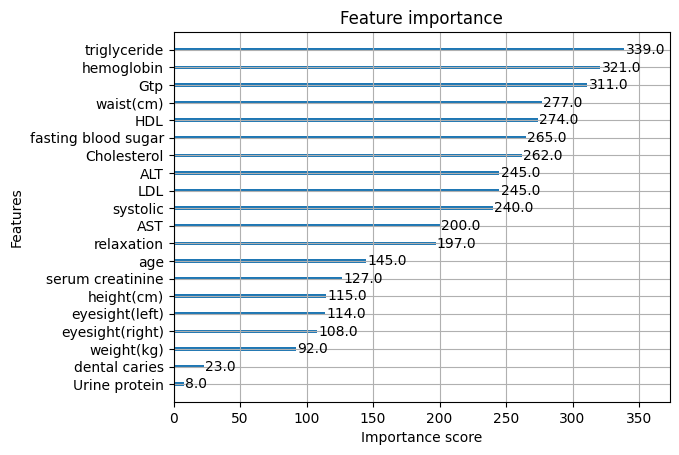

In [100]:
base_model = xgb.XGBClassifier(eval_metric="auc")
base_model.fit(X_train, y_train)
xgb.plot_importance(base_model)
roc_auc_score(y_val, base_model.predict_proba(X_val)[:, 1])

Boost and sort by importance:

In [101]:
booster = base_model.get_booster()
importance_dict = booster.get_score(importance_type="weight")
importance_df = pd.DataFrame.from_dict(
    importance_dict, orient="index", columns=["score"]
)
importance_df.index.name = "feature"
importance_df = importance_df.reset_index()

# Sort and get the least important
sorted_importance = importance_df.sort_values("score")

In [102]:
best_of_all_score = 0.0
best_of_all_model = None
best_of_all_name = None
best_of_all_params = None
best_of_all_drop_features = []

X_train_backup = X_train.copy()
X_val_backup = X_val.copy()

for feature_To_drop in range(0, 6):
    print(f"\n+++ Dropping {feature_To_drop} least important features +++")

    least_important_features = sorted_importance.head(feature_To_drop)["feature"].tolist()

    print(f"* Dropped features: {least_important_features}")

    X_train = X_train_backup.drop(columns=least_important_features)
    X_val = X_val_backup.drop(columns=least_important_features)

    for model_name, model_info in models.items():
        print(f"\n  --- Studying {model_name} ---")
        
        n_trials = model_info["trials"]
        objective = model_info["objective"]

        optuna_study = optuna.create_study(direction="maximize")
        
        with tqdm(total=n_trials) as pbar:
            def callback(study, trial):
                pbar.update(1)
                pbar.set_postfix({"best_value": f"{study.best_value:.3f}"})

            optuna_study.optimize(objective, n_trials=n_trials, callbacks=[callback])

        best_params = optuna_study.best_trial.params

        print(f"    * Best params: {best_params}")

        print(f"    * Best value: {optuna_study.best_value}")

        model = model_info["class"](**best_params)
        
        models[model_name]["best_model"] = model

    # Fit the best models

    print("\n* Fitting and evaluating the best models...")

    for model_name in models:
        models[model_name]["best_model"].fit(X_train, y_train)
        preds = models[model_name]["best_model"].predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, preds)
        print(f"    - {model_name} AUC: {auc_score:.4f}")

        if auc_score > best_of_all_score:
            best_of_all_score = auc_score
            best_of_all_model = models[model_name]["best_model"]
            best_of_all_name = model_name
            best_of_all_params = models[model_name]["best_model"].get_params()
            best_of_all_drop_features = least_important_features

    # Create a Voting Classifier with the best models

    print("\n* Creating Voting Classifier...")
    voting_model = VotingClassifier(
        estimators=[
            (name, model_info["best_model"]) for name, model_info in models.items()
        ],
        voting="soft",
    )
    voting_model.fit(X_train, y_train)
    voting_preds = voting_model.predict_proba(X_val)[:, 1]
    voting_auc = roc_auc_score(y_val, voting_preds)
    print(f"  - Voting Classifier AUC: {voting_auc:.4f}")

    if voting_auc > best_of_all_score:
        best_of_all_score = voting_auc
        best_of_all_model = voting_model
        best_of_all_name = "Voting Classifier"
        best_of_all_params = voting_model.get_params()
        best_of_all_drop_features = least_important_features



+++ Dropping 0 least important features +++
* Dropped features: []

  --- Studying ada_boost ---


100%|██████████| 40/40 [01:46<00:00,  2.67s/it, best_value=0.888]


    * Best params: {'n_estimators': 166, 'learning_rate': 0.22353855955795082, 'estimator': DecisionTreeClassifier(max_depth=3)}
    * Best value: 0.8879547528699744

  --- Studying logistic_regression ---


100%|██████████| 100/100 [01:25<00:00,  1.17it/s, best_value=0.876]


    * Best params: {'C': 4.003488263868796, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 306}
    * Best value: 0.8758206446034872

  --- Studying random_forest ---


100%|██████████| 60/60 [02:26<00:00,  2.44s/it, best_value=0.886]


    * Best params: {'n_estimators': 265, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}
    * Best value: 0.8857135309092655

  --- Studying xgboost ---


100%|██████████| 80/80 [00:09<00:00,  8.83it/s, best_value=0.893]


    * Best params: {'eta': 0.1364350041530636, 'max_depth': 4, 'subsample': 0.57015890736541, 'colsample_bytree': 0.8995596126983225, 'lambda': 9.920430265236966, 'alpha': 2.8812194801587734}
    * Best value: 0.8932782554397425

* Fitting and evaluating the best models...
    - ada_boost AUC: 0.8880
    - logistic_regression AUC: 0.8758
    - random_forest AUC: 0.8836
    - xgboost AUC: 0.8933

* Creating Voting Classifier...
  - Voting Classifier AUC: 0.8914

+++ Dropping 1 least important features +++
* Dropped features: ['Urine protein']

  --- Studying ada_boost ---


100%|██████████| 40/40 [02:07<00:00,  3.19s/it, best_value=0.890]


    * Best params: {'n_estimators': 256, 'learning_rate': 0.5386003755017258, 'estimator': DecisionTreeClassifier(max_depth=3)}
    * Best value: 0.8899860704164466

  --- Studying logistic_regression ---


100%|██████████| 100/100 [00:53<00:00,  1.86it/s, best_value=0.876]


    * Best params: {'C': 4.949116225950589, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 462}
    * Best value: 0.8761631202267158

  --- Studying random_forest ---


100%|██████████| 60/60 [02:38<00:00,  2.64s/it, best_value=0.886]


    * Best params: {'n_estimators': 252, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': True}
    * Best value: 0.8856703011672031

  --- Studying xgboost ---


100%|██████████| 80/80 [00:07<00:00, 10.23it/s, best_value=0.895]


    * Best params: {'eta': 0.41245240213116896, 'max_depth': 2, 'subsample': 0.9133152538726651, 'colsample_bytree': 0.8443130121208908, 'lambda': 6.093529704549698, 'alpha': 6.023709634197385}
    * Best value: 0.8948643066429702

* Fitting and evaluating the best models...
    - ada_boost AUC: 0.8900
    - logistic_regression AUC: 0.8762
    - random_forest AUC: 0.8853
    - xgboost AUC: 0.8949

* Creating Voting Classifier...
  - Voting Classifier AUC: 0.8925

+++ Dropping 2 least important features +++
* Dropped features: ['Urine protein', 'dental caries']

  --- Studying ada_boost ---


100%|██████████| 40/40 [01:16<00:00,  1.90s/it, best_value=0.887]


    * Best params: {'n_estimators': 140, 'learning_rate': 0.6031513033398499, 'estimator': DecisionTreeClassifier(max_depth=3)}
    * Best value: 0.8872690811278159

  --- Studying logistic_regression ---


100%|██████████| 100/100 [00:57<00:00,  1.73it/s, best_value=0.873]


    * Best params: {'C': 4.8722244228346225, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 593}
    * Best value: 0.8733416590614342

  --- Studying random_forest ---


100%|██████████| 60/60 [02:19<00:00,  2.32s/it, best_value=0.885]


    * Best params: {'n_estimators': 142, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}
    * Best value: 0.8849867909121476

  --- Studying xgboost ---


100%|██████████| 80/80 [00:13<00:00,  6.14it/s, best_value=0.890]


    * Best params: {'eta': 0.1467453717150466, 'max_depth': 17, 'subsample': 0.8489365282576886, 'colsample_bytree': 0.4257781166408388, 'lambda': 3.923695662653259, 'alpha': 8.583690130815693}
    * Best value: 0.8900561986646812

* Fitting and evaluating the best models...
    - ada_boost AUC: 0.8872
    - logistic_regression AUC: 0.8733
    - random_forest AUC: 0.8833
    - xgboost AUC: 0.8901

* Creating Voting Classifier...
  - Voting Classifier AUC: 0.8912

+++ Dropping 3 least important features +++
* Dropped features: ['Urine protein', 'dental caries', 'weight(kg)']

  --- Studying ada_boost ---


100%|██████████| 40/40 [01:10<00:00,  1.77s/it, best_value=0.886]


    * Best params: {'n_estimators': 113, 'learning_rate': 0.7173740115972632, 'estimator': DecisionTreeClassifier(max_depth=3)}
    * Best value: 0.8861825736106441

  --- Studying logistic_regression ---


100%|██████████| 100/100 [00:52<00:00,  1.89it/s, best_value=0.873]


    * Best params: {'C': 1.5833403076901473, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 316}
    * Best value: 0.8729098419712761

  --- Studying random_forest ---


100%|██████████| 60/60 [03:09<00:00,  3.16s/it, best_value=0.885]


    * Best params: {'n_estimators': 279, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}
    * Best value: 0.8848676689562419

  --- Studying xgboost ---


100%|██████████| 80/80 [00:08<00:00,  9.05it/s, best_value=0.892]


    * Best params: {'eta': 0.4570195103745014, 'max_depth': 3, 'subsample': 0.9996644463663702, 'colsample_bytree': 0.266212338463851, 'lambda': 0.8700212705831445, 'alpha': 9.638603098575931}
    * Best value: 0.8919602286373025

* Fitting and evaluating the best models...
    - ada_boost AUC: 0.8862
    - logistic_regression AUC: 0.8729
    - random_forest AUC: 0.8836
    - xgboost AUC: 0.8920

* Creating Voting Classifier...
  - Voting Classifier AUC: 0.8913

+++ Dropping 4 least important features +++
* Dropped features: ['Urine protein', 'dental caries', 'weight(kg)', 'eyesight(right)']

  --- Studying ada_boost ---


100%|██████████| 40/40 [01:20<00:00,  2.01s/it, best_value=0.887]


    * Best params: {'n_estimators': 103, 'learning_rate': 0.2736774304612159, 'estimator': DecisionTreeClassifier(max_depth=3)}
    * Best value: 0.8867236658821268

  --- Studying logistic_regression ---


100%|██████████| 100/100 [00:35<00:00,  2.80it/s, best_value=0.873]


    * Best params: {'C': 1.8442193340325832, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 884}
    * Best value: 0.8729372208079158

  --- Studying random_forest ---


100%|██████████| 60/60 [03:13<00:00,  3.22s/it, best_value=0.885]


    * Best params: {'n_estimators': 192, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}
    * Best value: 0.8849387578654114

  --- Studying xgboost ---


100%|██████████| 80/80 [00:10<00:00,  7.45it/s, best_value=0.890]


    * Best params: {'eta': 0.2556667708858527, 'max_depth': 6, 'subsample': 0.9638451366935853, 'colsample_bytree': 0.1892438284506539, 'lambda': 6.428685197662022, 'alpha': 6.049131898506063}
    * Best value: 0.8903785004082809

* Fitting and evaluating the best models...
    - ada_boost AUC: 0.8867
    - logistic_regression AUC: 0.8729
    - random_forest AUC: 0.8832
    - xgboost AUC: 0.8904

* Creating Voting Classifier...
  - Voting Classifier AUC: 0.8904

+++ Dropping 5 least important features +++
* Dropped features: ['Urine protein', 'dental caries', 'weight(kg)', 'eyesight(right)', 'eyesight(left)']

  --- Studying ada_boost ---


100%|██████████| 40/40 [01:56<00:00,  2.91s/it, best_value=0.885]


    * Best params: {'n_estimators': 211, 'learning_rate': 0.6729273148049524, 'estimator': DecisionTreeClassifier(max_depth=3)}
    * Best value: 0.8853367116576204

  --- Studying logistic_regression ---


100%|██████████| 100/100 [00:38<00:00,  2.61it/s, best_value=0.873]


    * Best params: {'C': 1.8382636873775378, 'penalty': 'l2', 'solver': 'liblinear', 'max_iter': 117}
    * Best value: 0.8726917719390941

  --- Studying random_forest ---


100%|██████████| 60/60 [03:27<00:00,  3.46s/it, best_value=0.885]


    * Best params: {'n_estimators': 192, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': False}
    * Best value: 0.8849891925644843

  --- Studying xgboost ---


100%|██████████| 80/80 [00:08<00:00,  9.79it/s, best_value=0.890]


    * Best params: {'eta': 0.13906537272966255, 'max_depth': 3, 'subsample': 0.3661912629170027, 'colsample_bytree': 0.8487753931738138, 'lambda': 3.5177436750192226, 'alpha': 4.976042381893}
    * Best value: 0.889665209664249

* Fitting and evaluating the best models...
    - ada_boost AUC: 0.8853
    - logistic_regression AUC: 0.8727
    - random_forest AUC: 0.8833
    - xgboost AUC: 0.8897

* Creating Voting Classifier...
  - Voting Classifier AUC: 0.8889


In [107]:
print("\n\n*** Best Model Summary ***")
print(f"Best Model Name: {best_of_all_name}")
print(f"Best Model AUC: {best_of_all_score:.4f}")
print(f"Best Model Dropped Features: {best_of_all_drop_features}")
print(f"Best Model Parameters:")

if type(best_of_all_model) == VotingClassifier:
    estimators = best_of_all_params['estimators']

    for name, model in estimators:
        print(f"  - {name}: {model.get_params()}")
else:
    print(best_of_all_params)



*** Best Model Summary ***
Best Model Name: xgboost
Best Model AUC: 0.8949
Best Model Dropped Features: ['Urine protein']
Best Model Parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8443130121208908, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 2, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subs

# Make Predictions on the Test Set

In [109]:
X_test = X_test.drop(columns=best_of_all_drop_features)

Then predict:

In [110]:
test_preds = best_of_all_model.predict_proba(X_test)[:, 1]
test_preds

array([0.5384288 , 0.02803622, 0.00560003, ..., 0.39475667, 0.00625331,
       0.63734525], shape=(10000,), dtype=float32)

And build the submission file:

In [111]:
submission = pd.DataFrame({
    "id": test_ids,
    "smoking": test_preds
})

submission

,id,smoking
0,15000,0.538429
1,15001,0.028036
2,15002,0.005600
3,15003,0.022746
4,15004,0.059893
...,...,...
9995,24995,0.007497
9996,24996,0.584260
9997,24997,0.394757
9998,24998,0.006253


In [112]:
submission.to_csv(f"{OUT_DIR}/smoking.csv", index=False)